# COCO Object Detection on GAP9

Import basic APIs from nntool module installed in the GAP SDK

In [29]:
from nntool.api import NNGraph
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib widget

## Import Model and adapt for GAP

Load the TFLite graph obtained from [Tensorflow Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf1_detection_zoo.md) in nntool and inspect the topology

In [2]:
G = NNGraph.load_graph("ssd_mobv1_quant.tflite", load_quantization=True)
G.draw()

Filter CONV_2D_0_34 of shape [3x3] is bigger than input of shape [2x2]


Convert the tensors ordering to the target SW backend library (default:CHW) and apply layer fusion (**Static topology optimizations**)

In [3]:
G.adjust_order()
G.fusions('scaled_match_group')
G.fusions('expression_matcher')
G.draw()
#print(G.show())

Invalid Context= "Action" line for icon theme:  "/usr/share/icons/Adwaita/8x8/legacy/"
Invalid Context= "Action" line for icon theme:  "/usr/share/icons/Adwaita/16x16/legacy/"
Invalid Context= "Action" line for icon theme:  "/usr/share/icons/Adwaita/16x16/ui/"
Invalid Context= "Action" line for icon theme:  "/usr/share/icons/Adwaita/22x22/legacy/"
Invalid Context= "Action" line for icon theme:  "/usr/share/icons/Adwaita/24x24/legacy/"
Invalid Context= "Action" line for icon theme:  "/usr/share/icons/Adwaita/24x24/ui/"
Invalid Context= "Action" line for icon theme:  "/usr/share/icons/Adwaita/32x32/legacy/"
Invalid Context= "Action" line for icon theme:  "/usr/share/icons/Adwaita/32x32/ui/"
Invalid Context= "Action" line for icon theme:  "/usr/share/icons/Adwaita/48x48/legacy/"
Invalid Context= "Action" line for icon theme:  "/usr/share/icons/Adwaita/48x48/ui/"
Invalid Context= "Action" line for icon theme:  "/usr/share/icons/Adwaita/64x64/legacy/"
Invalid Context= "Action" line for icon

Fuse multiple operators together to increase computation efficiency

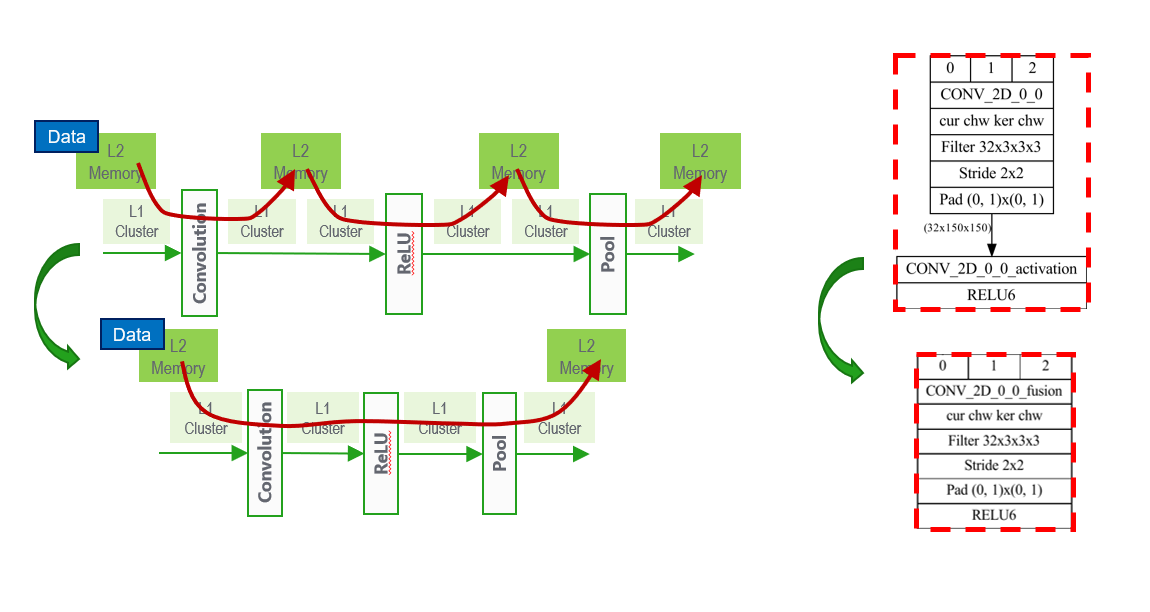

## Quantization

The most general formula to map integer values into real is the following affine transformation:

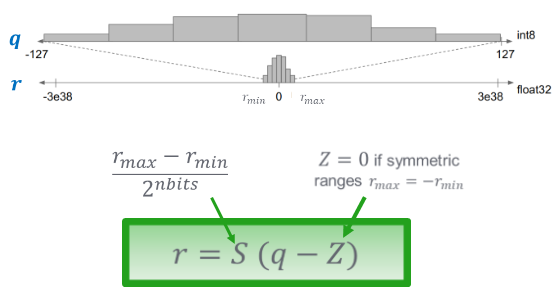

where $q$ is the quantized value (integer) representing the real value $r$. The parameters that define the quantization are:
- $ S = \frac{r_{max} - r_{min}}{2^{nbits}} $: the **Scaling Factor**. In GAP*flow* this value is always represented as exponent+mantissa (8+8bits unsigned)
- $ Z $: the **Zero Point**, i.e. the integer representation of the real value 0 (NOTE: the range is constrained to make 0 always representable). This value is always represented in the data type of $q$

The affine transformation can be applied tensor-wise ($S$ and $Z$ are scalar) or channel-wise ($S$ and $Z$ are arrays). Thanks to this representation, the operations of the graph can be moved to integer only arithmetic, leveraging HW acceleration (Conv accelerator, SIMD operations, ...). 

Accordingly to the target HW available in GAP (NE16, Cluster cores, FPUs) the supported quantization scheme might change:

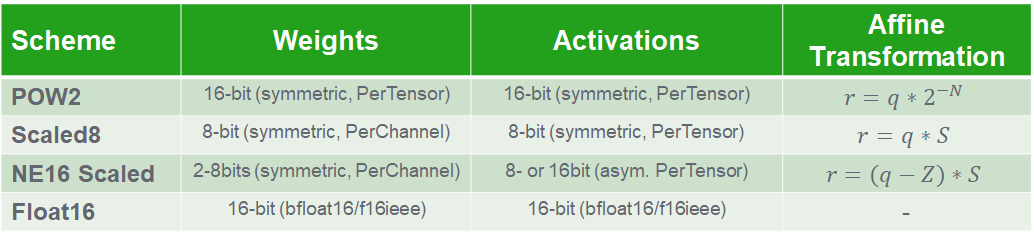

NOTE: Changing quantization type might change the target tensors ordering, for example NE16 conv accelerator works in HWC instead of default CHW. This tensor reordering is done by NNTool automatically after quantization. However the user might need to change the input order accordingly when running inference.

In order to collect $S$ and $Z$ for every tensor of the graph we need to collect statistics for intermidiate outputs.

We can use quantization statistics from tflite graph (in this case the model was quantized in tflite before export and therefore the ranges of the tensors have been loaded)

In [4]:
G.quantize(
    statistics=None, # Already quantized in tflite --> use the statistics from the graph itself
    graph_options={
        'bits': 8,
        'use_ne16': True,
        'hwc': True
    },
)

indicating change of CONV_2D_0_0 input from chw, out_cin_chw, out_c to hwc, out_cin_chw, out_c order - rerun adjust command
indicating change of CONV_2D_0_0 output from chw to hwc order - rerun adjust command
indicating change of DEPTHWISE_CONV_2D_0_1 input from chw, out_cin_chw, out_c to hwc, out_cin_chw, out_c order - rerun adjust command
indicating change of DEPTHWISE_CONV_2D_0_1 output from chw to hwc order - rerun adjust command
indicating change of CONV_2D_0_2 input from chw, out_cin_chw, out_c to hwc, out_cin_chw, out_c order - rerun adjust command
indicating change of CONV_2D_0_2 output from chw to hwc order - rerun adjust command
indicating change of DEPTHWISE_CONV_2D_0_3 input from chw, out_cin_chw, out_c to hwc, out_cin_chw, out_c order - rerun adjust command
indicating change of DEPTHWISE_CONV_2D_0_3 output from chw to hwc order - rerun adjust command
indicating change of CONV_2D_0_4 input from chw, out_cin_chw, out_c to hwc, out_cin_chw, out_c order - rerun adjust command


Or we can collect again quantization statistics using NNTool numpy inference engine

In [5]:
from tqdm import tqdm
CALIBRATION_IMGS = ["coco_test_image.ppm"]
def representative_dataset():
    for image in tqdm(CALIBRATION_IMGS):
        yield np.array(Image.open(image)) / 128 - 1

stats = G.collect_statistics(representative_dataset())
G.quantize(
    statistics=stats,
    graph_options={
        'bits': 8,
        'use_ne16': True,
        'hwc': True
    },
    # Select specific nodes and move to different quantization Scheme - TOTAL FLEXIBILITY
    #node_options={
    #    G[3].name: {
    #        "scheme": "FLOAT",
    #        "float_type": "bfloat16"
    #    },
    #    ...
    #}
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.37s/it]


In [6]:
G.draw(quant_labels=True)

Invalid Context= "Action" line for icon theme:  "/usr/share/icons/Adwaita/8x8/legacy/"
Invalid Context= "Action" line for icon theme:  "/usr/share/icons/Adwaita/16x16/legacy/"
Invalid Context= "Action" line for icon theme:  "/usr/share/icons/Adwaita/16x16/ui/"
Invalid Context= "Action" line for icon theme:  "/usr/share/icons/Adwaita/22x22/legacy/"
Invalid Context= "Action" line for icon theme:  "/usr/share/icons/Adwaita/24x24/legacy/"
Invalid Context= "Action" line for icon theme:  "/usr/share/icons/Adwaita/24x24/ui/"
Invalid Context= "Action" line for icon theme:  "/usr/share/icons/Adwaita/32x32/legacy/"
Invalid Context= "Action" line for icon theme:  "/usr/share/icons/Adwaita/32x32/ui/"
Invalid Context= "Action" line for icon theme:  "/usr/share/icons/Adwaita/48x48/legacy/"
Invalid Context= "Action" line for icon theme:  "/usr/share/icons/Adwaita/48x48/ui/"
Invalid Context= "Action" line for icon theme:  "/usr/share/icons/Adwaita/64x64/legacy/"
Invalid Context= "Action" line for icon

## Validate quantized model in python

Once the model is ready, we can evaluate its numerical behaviour on real samples through python APIs with bit-accurate results wrt the real HW

In [7]:
input_image = np.array(Image.open("coco_test_image.ppm"))
# Normalize data between -1:1 as model requires
input_data = input_image / 128 - 1.0

In [8]:
#fig, ax = plt.subplots()
#ax.imshow(input_image)

Run inference in NNTool with full-precision and quantized backend (integer numpy: GAP9 bit-accurate). Dequantize the integer results to make the comparison with the fp32 execution (dequantize=True)

In [9]:
float_execution = G.execute([input_data], quantize=False)
quant_execution = G.execute([input_data], quantize=True, dequantize=True)

Analize numeric differences between full precision and quantized

In [10]:
from nntool.graph.types import ConstantInputNode
qsnrs_by_layer = G.qsnrs(float_execution, quant_execution)
print("QSNR layer by layer (skipping constant layers like weights and biases):")
print(f"{'Layer Name':>30} (  #): {'QSNR':4}")
for i, q in enumerate(qsnrs_by_layer):
    if isinstance(G[i], ConstantInputNode):
        continue
    print(f"{G[i].name:>30} ({i:3}): {q:4}")

QSNR layer by layer (skipping constant layers like weights and biases):
                    Layer Name (  #): QSNR
                       input_1 (  0):   47
            CONV_2D_0_0_fusion (  3):   44
  DEPTHWISE_CONV_2D_0_1_fusion (  6):   35
            CONV_2D_0_2_fusion (  9):   30
  DEPTHWISE_CONV_2D_0_3_fusion ( 12):   32
            CONV_2D_0_4_fusion ( 15):   30
  DEPTHWISE_CONV_2D_0_5_fusion ( 18):   30
            CONV_2D_0_6_fusion ( 21):   28
  DEPTHWISE_CONV_2D_0_7_fusion ( 24):   31
            CONV_2D_0_8_fusion ( 27):   29
  DEPTHWISE_CONV_2D_0_9_fusion ( 30):   27
           CONV_2D_0_10_fusion ( 33):   27
 DEPTHWISE_CONV_2D_0_11_fusion ( 36):   29
           CONV_2D_0_12_fusion ( 39):   27
 DEPTHWISE_CONV_2D_0_13_fusion ( 42):   25
           CONV_2D_0_14_fusion ( 45):   27
 DEPTHWISE_CONV_2D_0_15_fusion ( 48):   27
           CONV_2D_0_16_fusion ( 51):   25
 DEPTHWISE_CONV_2D_0_17_fusion ( 54):   26
           CONV_2D_0_18_fusion ( 57):   24
 DEPTHWISE_CONV_2D_0_19_f

In [11]:
def visualize_bboxes(original_image, bboxes, classes, scores, qbboxes=None, qclasses=None, qscores=None, color="red", title=None):
    # Create figure and axes
    fig, ax = plt.subplots(1, 2 if qbboxes is not None else 1)

    h, w = input_image.shape[0], input_image.shape[1]
    for box, score, class_id in zip(bboxes, scores, classes):
        # Create a Rectangle patch
        bot, left = int(box[0] * w), int(box[1] * w)
        box_w, box_h = int((box[3]-box[1]) * w), int((box[2]-box[0]) * h)
        rect = patches.Rectangle((left, bot), box_w, box_h, linewidth=1, edgecolor=color, facecolor='none')
        ax[0].text(left, bot+box_h, int(class_id), color="g")
        ax[0].add_patch(rect)
    # Display the image
    ax[0].imshow(original_image)
    ax[0].set_title("Full-precision")

    if qbboxes is not None:
        for box, score, class_id in zip(qbboxes, qscores, qclasses):
            # Create a Rectangle patch
            bot, left = int(box[0] * w), int(box[1] * w)
            box_w, box_h = int((box[3]-box[1]) * w), int((box[2]-box[0]) * h)
            rect = patches.Rectangle((left, bot), box_w, box_h, linewidth=1, edgecolor=color, facecolor='none')
            ax[1].text(left, bot+box_h, int(class_id), color="g")
            ax[1].add_patch(rect)
        # Display the image
        ax[1].imshow(original_image)
        ax[1].set_title("Quantized")

    if title:
        fig.suptitle(title, fontsize=16)
    #fig.show()


In [12]:
float_bboxes, float_classes, float_scores = [float_execution[out_node.step_idx][0] for out_node in G.outputs()]
quant_bboxes, quant_classes, quant_scores = [quant_execution[out_node.step_idx][0] for out_node in G.outputs()]

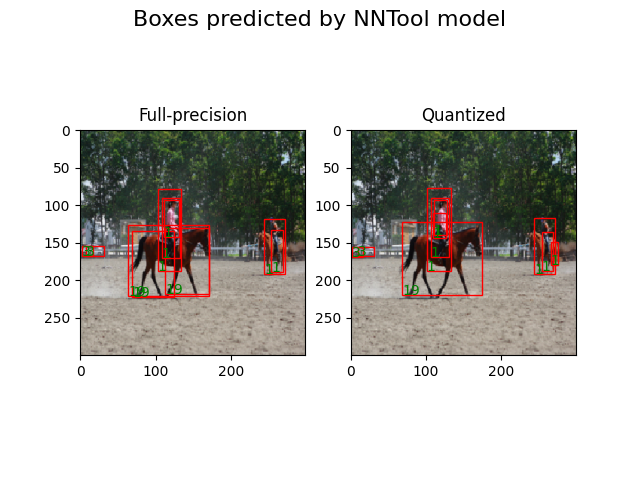

In [13]:
visualize_bboxes(
    input_image, float_bboxes, float_classes, float_scores,
    quant_bboxes, quant_classes, quant_scores,
    color="red", title="Boxes predicted by NNTool model"
)

## Execute on target

Once we are fine with the numerical behaviour of the model we can run it on the HW (or gvsoc simulator) to get actual perfomance metrics

In [14]:
# On the target only fully integer values - NO DEQUANTIZE
int_execution = G.execute([input_data], dequantize=False, quantize=True)

In [34]:
# Autotiler options: make the autotiler allocate the input of the network and reuse that space after the first layer
# more L2 for the rest of the network
G[0].at_options.allocate = 1
G[0].at_options

{'ALLOCATE': 1}

In [30]:
res = G.execute_on_target(
    pmsis_os='freertos',
    platform="gvsoc",
    directory="/home/marco-gwt/GWT/nn_experiments/coco_notebook_2/test_run",
    input_tensors=int_execution[0],
    output_tensors=0,
    write_out_to_file=True,
    at_log=True,
    dont_run=False,
    settings={
        'l1_size': 128000,
        'l2_size': 1300000,
        'tensor_directory': './tensors'
    }
)
for l in res.at_log[-29:-1]:
    print(l)

      Shared L1 Memory size (Bytes)       : Given:     115712, Used:     115688
             L2 Memory size (Bytes)       : Given:    1300000, Used:    1300000
       HyperRam Memory size (Bytes)       : Given:    8000000, Used:    7999996
     HyperFlash Memory size (Bytes)       : Given:   67108864, Used:    6898612
    L2 Promoted Tensors Usage (Bytes)     :                               94384
    Total Flash Used at runtime (Bytes)   :                    Used:    6804228 (317937+0)

L3 Memory bandwidth for 1 graph run       :   14270442 Bytes
L2 Memory bandwidth for 1 graph run       :   60400490 Bytes
Sum of all Kernels arguments size         :   26952506 Bytes
Tiling Bandwith overhead                  :   2.240997 Move/KerArgSize
Sum of baseline bandwidth                 : 1197828408 Bytes
Percentage of baseline BW for L2          :     5.0425 %
Percentage of baseline BW for L3          :    1.19136 %
Sum of all Kernels operations             : 1246802626 Operations
Total amount 

What's going on? A project folder is created at "directory" path (standard main function, build files, compiler flags, ...) from a template. NNTool generated the Autotiler Model and it has been compiled and run. Extra options to the AT can be passed here like the prefered external memory or the size of the different memory levels.

The C-code generated by the Autotiler is then compiled along with the AT Library in the GAP SDK and the files generated by the project template. The application code simply takes the "input_tensors" and run inference on the target platform, then writes out the outputs to files.

In [31]:
cyc_per_layer = np.array(res.performance)[:-1, 1].astype(np.int32)
opcyc_per_layer = np.array(res.performance)[:-1, 3].astype(np.float32)
perc_per_layer = np.array(res.performance)[:-1, -1].astype(np.float32)
names = np.array(res.performance)[:-1, 0]
def print_perf_layer(res):
    layer_idx = [n.split("_")[0][1:] for n in names]
    #print(cyc_per_layer)
    print(f"{'Layer':>40} | {'Cycles':8} | {'Op':10} | {'Op/Cyc':8} | {'%':8}\n")
    for n, cyc, op, opcyc, perc in res.performance:
        if n == "Total":
            print()
        print(f"{n:>40} | {cyc:8} | {op:10} | {float(opcyc):8.2f} | {float(perc):8.2f}")


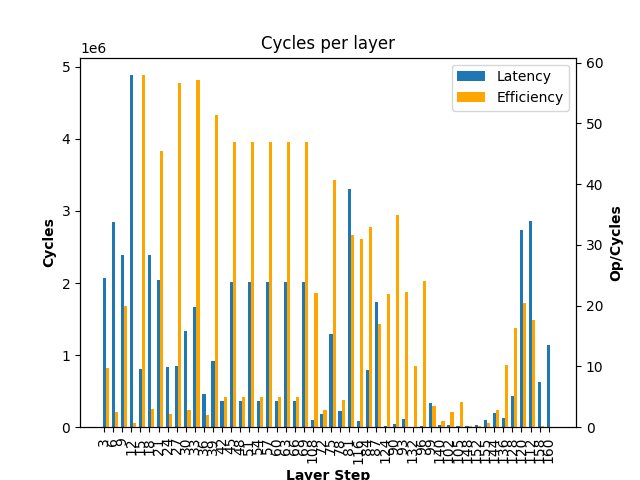

In [32]:
fig, ax = plt.subplots()
barWidth = 0.35

# Set position of bar on X axis
br1 = np.arange(len(cyc_per_layer))
br2 = [x + barWidth for x in br1]

lns = []
lns.append(
    ax.bar(br1, cyc_per_layer, width = barWidth, label="Latency")
)
ax1 = ax.twinx()
lns.append(
    ax1.bar(br2, opcyc_per_layer, width = barWidth, color="orange", label="Efficiency")
)
ax.set_xlabel('Layer Step', fontweight ='bold')#, fontsize = 15)
ax.set_ylabel('Cycles', fontweight ='bold')#, fontsize = 15)
ax1.set_ylabel('Op/Cycles', fontweight ='bold')#, fontsize = 15)
ax.set_xticks([r for r in range(len(names))], [name.split("_")[0][1:] for name in names], rotation=90)
ax.set_title("Cycles per layer")

labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc="upper right")

plt.show()

In [33]:
print_perf_layer(res)

                                   Layer | Cycles   | Op         | Op/Cyc   | %       

                S3_Conv2d_32x3x3x3_Relu6 |  2075918 |   20160000 |     9.71 |     3.99
                S6_Conv2d_32x1x3x3_Relu6 |  2853779 |    7200000 |     2.52 |     5.48
               S9_Conv2d_64x32x1x1_Relu6 |  2391601 |   47520000 |    19.87 |     4.60
               S12_Conv2d_64x1x3x3_Relu6 |  4883717 |    3600000 |     0.74 |     9.39
             S15_Conv2d_128x64x1x1_Relu6 |   808074 |   46800000 |    57.92 |     1.55
              S18_Conv2d_128x1x3x3_Relu6 |  2392777 |    7200000 |     3.01 |     4.60
            S21_Conv2d_128x128x1x1_Relu6 |  2040528 |   92880000 |    45.52 |     3.92
              S24_Conv2d_128x1x3x3_Relu6 |   840836 |    1848320 |     2.20 |     1.62
            S27_Conv2d_256x128x1x1_Relu6 |   842629 |   47686656 |    56.59 |     1.62
              S30_Conv2d_256x1x3x3_Relu6 |  1335304 |    3696640 |     2.77 |     2.57
            S33_Conv2d_256x256x1x1_Relu6 |

In [35]:
out1 = np.fromfile("test_run/Output_1.bin", np.int16)

In [36]:
print("Out Name, QSNR NNTool vs Target run")
for outn in G.output_nodes():
    out_target = np.fromfile(f"test_run/{outn.name.capitalize()}.bin", G.quantization[outn.name].in_qs[0].dtype)
    out_nntool = int_execution[G[outn.name].step_idx]
    print(f"{outn.name}, {G.qsnrs([out_target], [out_nntool[0].flatten()])}")

Out Name, QSNR NNTool vs Target run
output_1, (inf,)
output_2, (inf,)
output_3, (inf,)
